🔍 Exploring optimal number of steps...

📊 Step Optimization Summary
 Steps  Optimal p  Min Avg Cost (₹)
     8   4.974879         56.748154
    10   4.993195         57.182908
    15   4.934225         57.872356
    20   4.985162         58.072571
    30   4.984795         58.340095
    40   4.970651         58.476234
✅ Recommended Number of Steps: 8
   → Corresponding Optimal p: 4.975
   → Minimum Average Cost: ₹56.748


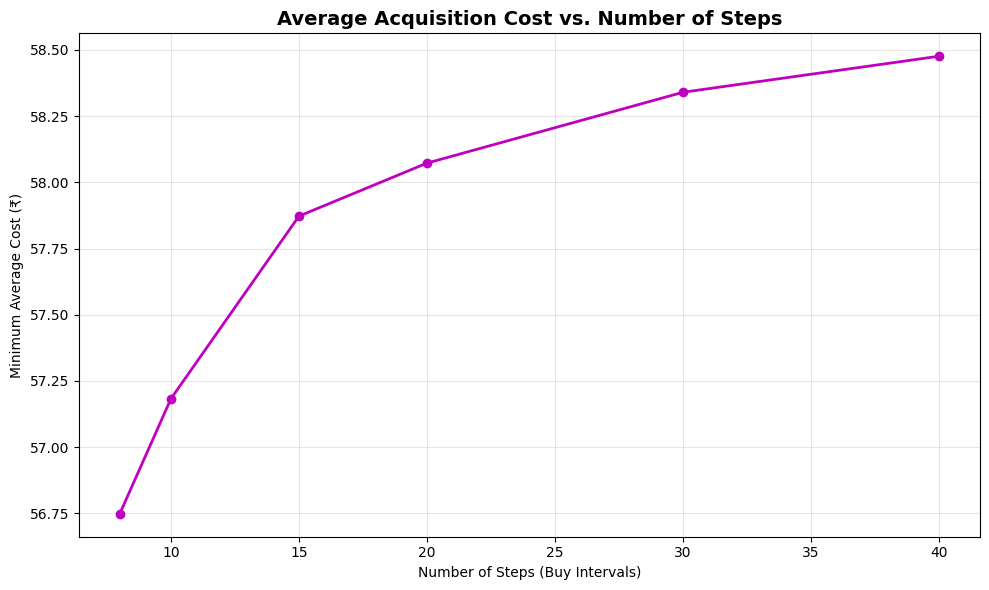


💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY
 Step  Price (₹)  Investment (₹)  Quantity  Actual Invested (₹)  Cumulative Qty  Average Cost (₹)
    1     100.00         1261.41        12              1200.00              12           100.000
    2      90.57         2064.41        22              1992.59              34            93.900
    3      82.03         3378.61        41              3363.37              75            87.413
    4      74.30         5529.41        74              5498.18             149            80.900
    5      67.30         9049.40       134              9017.53             283            74.458
    6      60.95        14810.20       242             14750.07             525            68.232
    7      55.20        24238.30       439             24234.76             964            62.299
    8      50.00        39668.26       793             39650.00            1757            56.748
Optimal weighting exponent (p): 4.975
Minimum achievable average cost: ₹56.

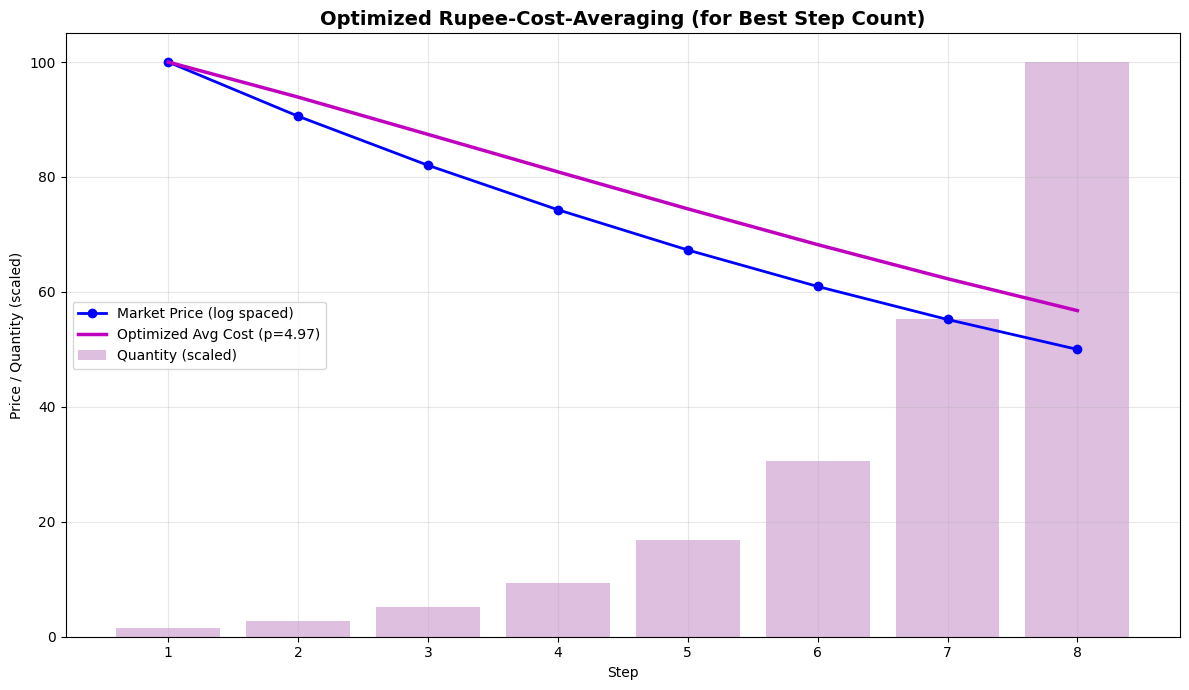

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar


# =====================================================
# 1️⃣ COMPUTATION MODULE
# =====================================================
def simulate_dca(prices, total_investment, p):
    """
    Simulate Rupee-Cost-Averaging with weighting proportional to (1/price)^p.
    Returns DataFrame, cumulative stats, and average cost.
    """
    weights = (1 / prices) ** p
    weights /= np.sum(weights)

    investments = total_investment * weights
    quantities = np.floor(investments / prices).astype(int)
    actual_investments = quantities * prices

    cumulative_qty = np.cumsum(quantities)
    cumulative_investment = np.cumsum(actual_investments)
    avg_cost = cumulative_investment / np.maximum(cumulative_qty, 1)

    df = pd.DataFrame(
        {
            "Step": np.arange(1, len(prices) + 1),
            "Price (₹)": np.round(prices, 2),
            "Investment (₹)": np.round(investments, 2),
            "Quantity": quantities,
            "Actual Invested (₹)": np.round(actual_investments, 2),
            "Cumulative Qty": cumulative_qty,
            "Average Cost (₹)": np.round(avg_cost, 3),
        }
    )

    total_qty = cumulative_qty[-1]
    total_spent = cumulative_investment[-1]

    return df, total_qty, total_spent, avg_cost[-1]


# =====================================================
# 2️⃣ OPTIMIZATION MODULE
# =====================================================
def find_optimal_p(prices, total_investment, bounds=(0, 5)):
    """Find the exponent p minimizing average acquisition cost."""

    def avg_cost_for_p(p):
        _, total_qty, total_spent, avg_cost = simulate_dca(prices, total_investment, p)
        return avg_cost if total_qty > 0 else np.inf

    result = minimize_scalar(avg_cost_for_p, bounds=bounds, method="bounded")
    return result.x, result.fun


# =====================================================
# 3️⃣ NEW MODULE: STEP OPTIMIZATION
# =====================================================
def find_optimal_num_steps(
    step_candidates,
    initial_price,
    final_price,
    total_investment,
):
    """
    Explore multiple step counts and find the one that yields minimum average cost.
    Returns a summary DataFrame and the best step configuration.
    """
    results = []

    for num_steps in step_candidates:
        prices = np.geomspace(initial_price, final_price, num_steps)
        opt_p, min_avg_cost = find_optimal_p(prices, total_investment)
        results.append((num_steps, opt_p, min_avg_cost))

    df_results = pd.DataFrame(
        results, columns=["Steps", "Optimal p", "Min Avg Cost (₹)"]
    )

    best_row = df_results.loc[df_results["Min Avg Cost (₹)"].idxmin()]
    best_steps = int(best_row["Steps"])
    best_p = best_row["Optimal p"]
    best_cost = best_row["Min Avg Cost (₹)"]

    return df_results, best_steps, best_p, best_cost


# =====================================================
# 4️⃣ PLOTTING + REPORTING MODULE
# =====================================================
def plot_and_report(
    df,
    prices,
    total_qty,
    total_spent,
    final_price,
    opt_p,
    min_avg_cost,
    target_sell_price,
):
    """Visualize and print insights for the optimized DCA strategy."""
    cumulative_qty = df["Cumulative Qty"].values
    avg_cost = df["Average Cost (₹)"].values
    steps = df["Step"].values

    # Final statistics
    final_value = total_qty * final_price
    profit_loss = final_value - total_spent
    profit_loss_pct = (profit_loss / total_spent) * 100

    print("\n💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY")
    print("=" * 90)
    print(df.to_string(index=False))
    print("=" * 90)
    print(f"Optimal weighting exponent (p): {opt_p:.3f}")
    print(f"Minimum achievable average cost: ₹{min_avg_cost:.3f}")
    print(f"Total Quantity Acquired: {total_qty}")
    print(f"Total Invested: ₹{total_spent:,.2f}")
    print(f"Final Price: ₹{final_price:.2f}")
    print(f"Final Portfolio Value: ₹{final_value:,.2f}")
    print(f"Profit/Loss: ₹{profit_loss:,.2f} ({profit_loss_pct:+.2f}%)")
    print("=" * 90)

    # Target simulation
    target_portfolio_value = total_qty * target_sell_price
    target_profit_loss = target_portfolio_value - total_spent
    target_profit_loss_pct = (target_profit_loss / total_spent) * 100

    print("\n🎯 TARGET SELL SIMULATION")
    print("=" * 90)
    print(f"Target Sell Price: ₹{target_sell_price:.2f}")
    print(f"Portfolio Value at Target: ₹{target_portfolio_value:,.2f}")
    print(
        f"Expected Profit/Loss: ₹{target_profit_loss:,.2f} ({target_profit_loss_pct:+.2f}%)"
    )
    print("=" * 90)

    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(steps, prices, "bo-", linewidth=2, label="Market Price (log spaced)")
    plt.plot(
        steps,
        avg_cost,
        "m-",
        linewidth=2.5,
        label=f"Optimized Avg Cost (p={opt_p:.2f})",
    )
    plt.bar(
        steps,
        df["Quantity"] * (max(prices) / max(df["Quantity"])),
        color="purple",
        alpha=0.25,
        label="Quantity (scaled)",
    )

    plt.title(
        "Optimized Rupee-Cost-Averaging (for Best Step Count)",
        fontsize=14,
        weight="bold",
    )
    plt.xlabel("Step")
    plt.ylabel("Price / Quantity (scaled)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_step_analysis(df_results):
    """Plot average cost vs. number of steps."""
    plt.figure(figsize=(10, 6))
    plt.plot(df_results["Steps"], df_results["Min Avg Cost (₹)"], "o-m", linewidth=2)
    plt.title(
        "Average Acquisition Cost vs. Number of Steps", fontsize=14, weight="bold"
    )
    plt.xlabel("Number of Steps (Buy Intervals)")
    plt.ylabel("Minimum Average Cost (₹)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =====================================================
# 5️⃣ MAIN CLI INTERFACE
# =====================================================
def main():
    total_investment = 100000  # INR
    initial_price = 100
    final_price = 50
    target_sell_price = 120

    # Candidate step counts to explore (easy to adjust)
    step_candidates = [8, 10, 15, 20, 30, 40]

    print("🔍 Exploring optimal number of steps...")
    df_results, best_steps, best_p, best_cost = find_optimal_num_steps(
        step_candidates, initial_price, final_price, total_investment
    )

    # Show summary of all tested configurations
    print("\n📊 Step Optimization Summary")
    print("=" * 60)
    print(df_results.to_string(index=False))
    print("=" * 60)
    print(f"✅ Recommended Number of Steps: {best_steps}")
    print(f"   → Corresponding Optimal p: {best_p:.3f}")
    print(f"   → Minimum Average Cost: ₹{best_cost:.3f}")

    # Plot cost vs. steps
    plot_step_analysis(df_results)

    # Run detailed simulation for best configuration
    prices = np.geomspace(initial_price, final_price, best_steps)
    df, total_qty, total_spent, _ = simulate_dca(prices, total_investment, best_p)

    # Plot and report final detailed strategy
    plot_and_report(
        df,
        prices,
        total_qty,
        total_spent,
        final_price,
        best_p,
        best_cost,
        target_sell_price,
    )


# =====================================================
# ENTRY POINT
# =====================================================
if __name__ == "__main__":
    main()